In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [2]:
sc.set_figure_params(dpi=100, frameon=False, color_map='Reds')
sc.logging.print_header()

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


scanpy==1.6.0 anndata==0.7.4 umap==0.4.6 numpy==1.19.2 scipy==1.6.1 pandas==1.2.3 scikit-learn==0.23.2 statsmodels==0.11.1 python-igraph==0.8.3 leidenalg==0.8.3


In [3]:
import warnings
warnings.filterwarnings('ignore')

/home/icb/yuge.ji/miniconda3/envs/py37/lib/python3.7/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
# replicate Meshal's pretty plotting colors
from matplotlib import colors
gray_red = colors.LinearSegmentedColormap.from_list("grouping", ["lightgray", "red", "darkred"], N = 128)

In [5]:
def repeat(f):
    d = {}
    for p, adata in adatas.items():
        d[p] = f(p, adata)
    return d

In [6]:
%%time
adatas = {
    f'patient_{p}': sc.read(f'/storage/groups/ml01/workspace/yuge.ji/covid-perturbation/data/210118_annot_patient_{p}.h5ad') for p in [1, 2, 3, 4]
}

CPU times: user 44.1 s, sys: 47.5 s, total: 1min 31s
Wall time: 1min 34s


Add `infected` label based on de-multiplexing.

In [55]:
import math
def f(p, adata):
    adata.obs['infected'] = ['sars-cov-2' in s if not pd.isnull(s) else math.nan for s in adata.obs.treatment_virus.values]
    adata.obs['infected'] = adata.obs['infected'].astype('category')
    
    # for plotting
    adata.obs['log2(viral_counts)'] = np.log2(adata.obs['viral_counts'].values + 1)
    return adata[~adata.obs.infected.isna()]

adatas = repeat(f)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Distribution of viral counts in infected vs. uninfected samples, according to demultiplexed labels. This demonstrates that the infection and demultiplexing performed decently as cells labeled as infected have overall more virus than cells labeled as uninfected.

Trying to set attribute `.obs` of view, copying.


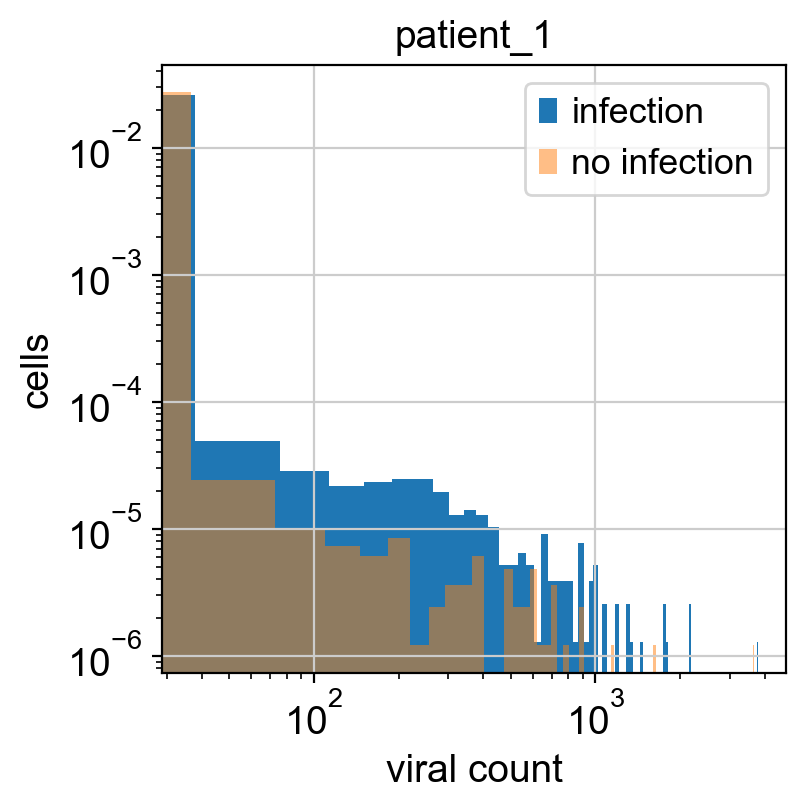

Trying to set attribute `.obs` of view, copying.


Background level: 2.0


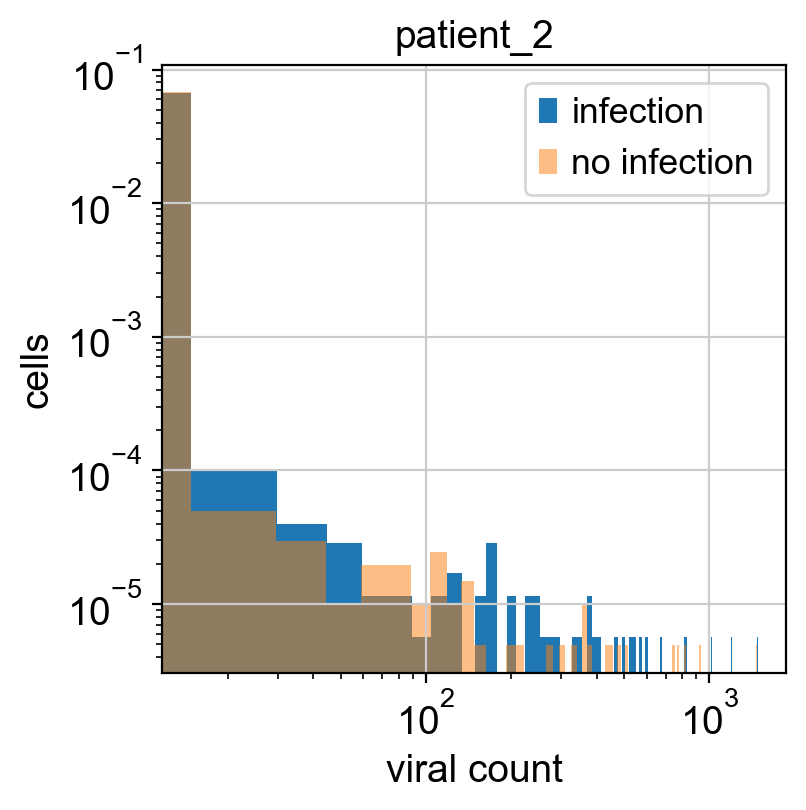

Trying to set attribute `.obs` of view, copying.


Background level: 2.0


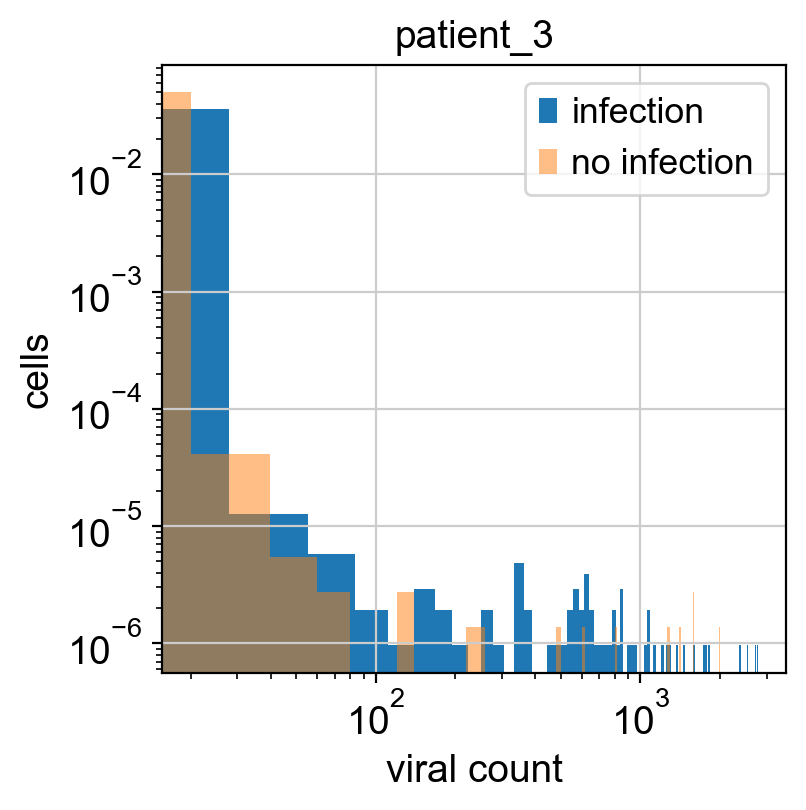

Trying to set attribute `.obs` of view, copying.


Background level: 2.0


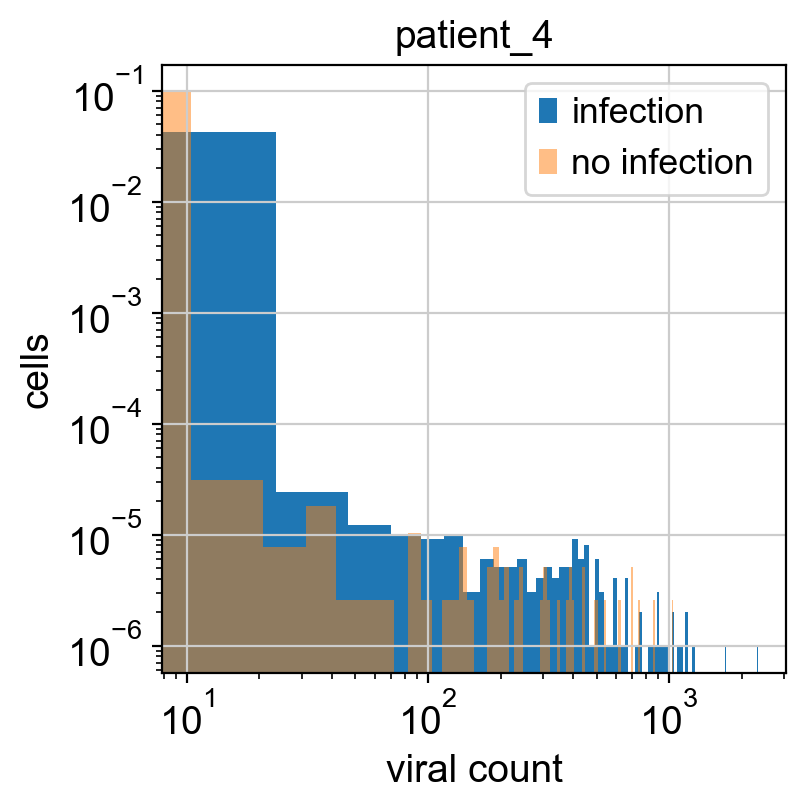

Background level: 2.0


{'patient_1': 427.9519999998447,
 'patient_2': 277.1000000000131,
 'patient_3': 23.305999999996857,
 'patient_4': 105.39999999993597}

In [8]:
import scipy as sp
def distr_plot(p, adata):
    adata.obs['infected'] = ['sars-cov-2' in s if not pd.isnull(s) else math.nan for s in adata.obs.treatment_virus.values]
    inf_values = plt.hist(adata[adata.obs.infected == True].obs.viral_counts.values, bins=100, label='infection', density=True)
    no_inf = adata[adata.obs.infected == False].obs.viral_counts.values
    no_inf_values = plt.hist(no_inf, bins=100, alpha=.5, label='no infection', density=True)
    plt.xlabel('viral count')
    plt.ylabel('% of cells')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.title(p)
    plt.show()
    
    # Calculate a background level of viral count based on the average in the `no infection` samples.
    thresh = np.quantile(no_inf, .99)
    print('Background level:', thresh)
    
    return thresh
                 
bg_lvl = repeat(distr_plot)                 
bg_lvl_high = repeat(lambda p, adata: np.quantile(adata[adata.obs.infected == False].obs.viral_counts.values, .999))
bg_lvl_high

Reference from Ravindra et al. (2021), where cells have much higher viral expression overall, but a similar infection rate on day 1 to our data:   
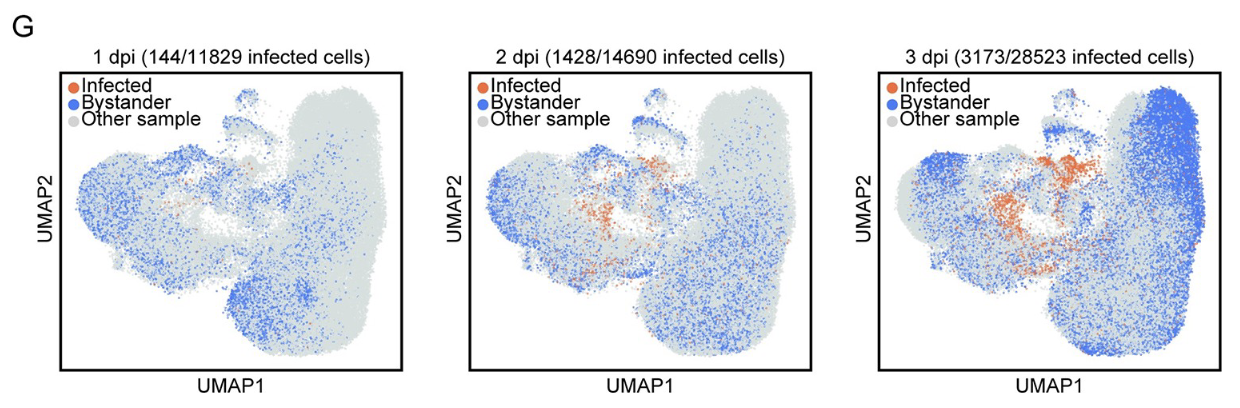
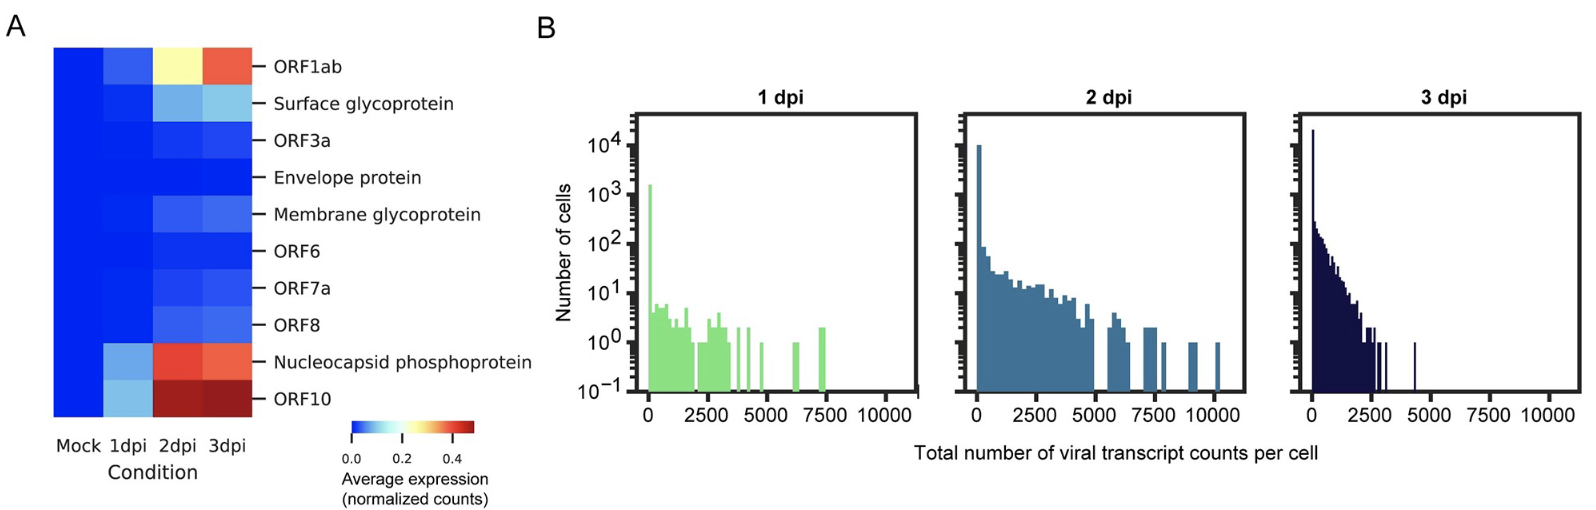

Number of infected cells (where infection = viral count > 10)
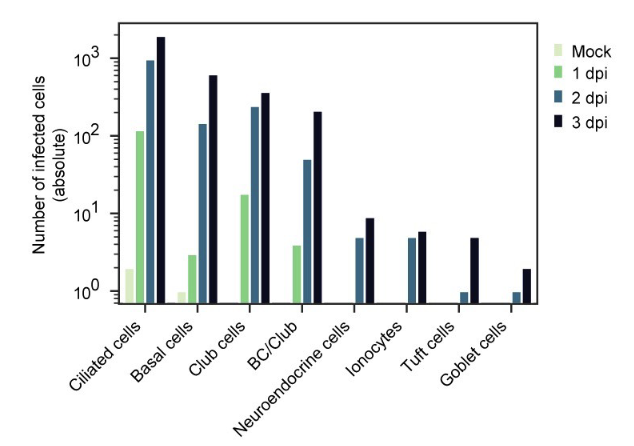

In [62]:
(144*100/118000)

0.12203389830508475

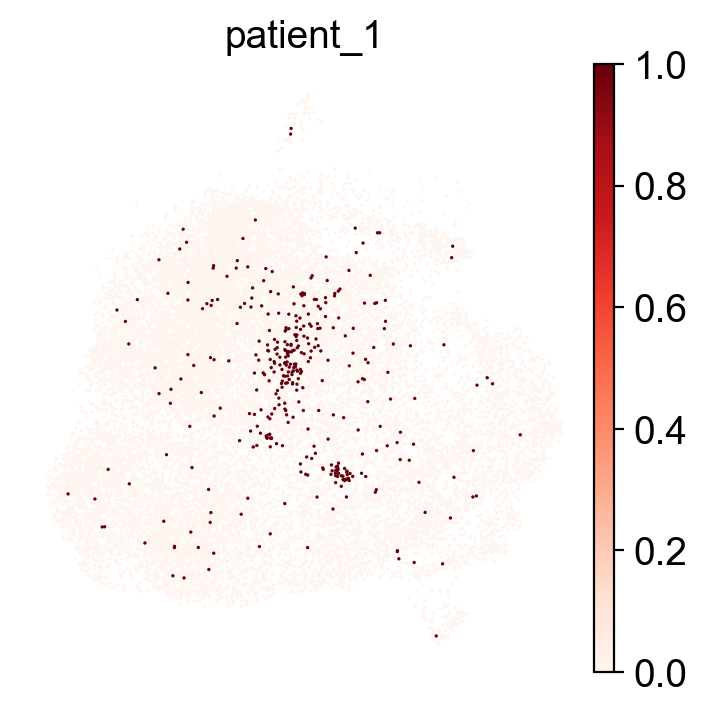

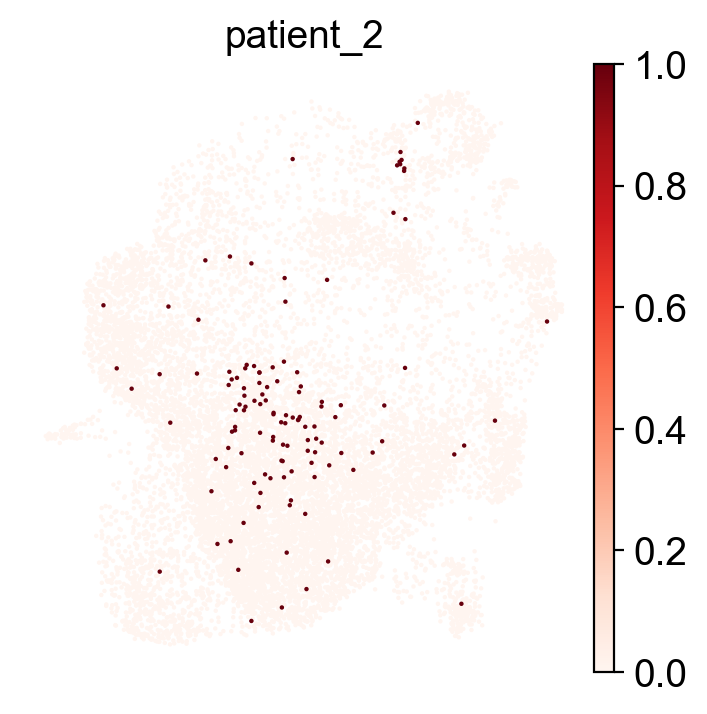

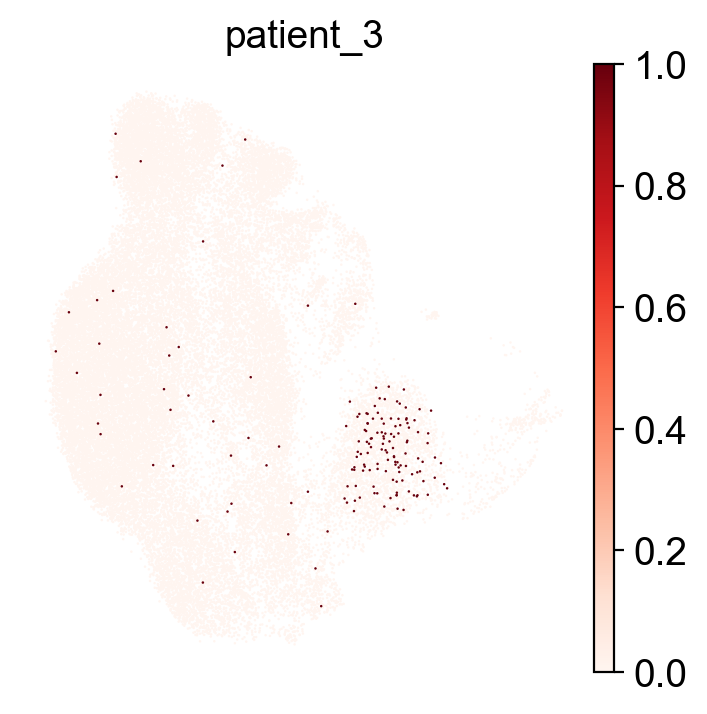

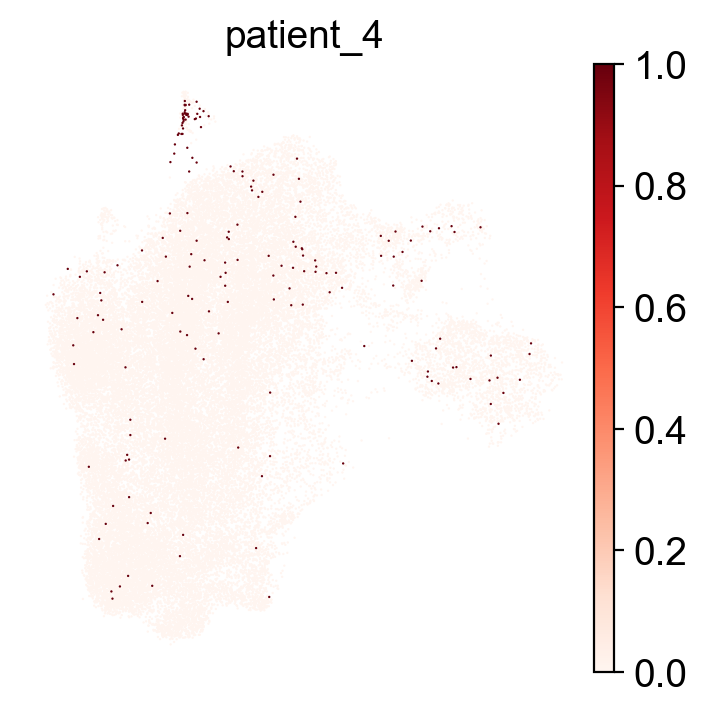

{'patient_1': None, 'patient_2': None, 'patient_3': None, 'patient_4': None}

In [9]:
# plot infected but not heavily infected cells
def f(p, adata):
    adata.obs['infected_thresh'] = [x > bg_lvl[p] and x < bg_lvl_high[p] for x in adata.obs.viral_counts]
    sc.pl.umap(adata[adata.obs.infected], color='infected_thresh', palette='Reds', title=p)
    
repeat(f)

It is possible that there is only an enrichment for viral counts in certain patients...?

In [52]:
from scipy.stats import ttest_ind
# convenience function for standard plotting
def plot(df):
    sns.boxplot(
        data = df.T, orient='horizontal',
        color='white'
    )
    sns.stripplot(data = df.T, orient='horizontal', color='.3', size=4)

In [56]:
import anndata as ad
adata = ad.concat(adatas)

### % infected per treatment

#### Based on % threshold

Fiege et al. (2021), for reference - they pick up many, many more viral transcripts:
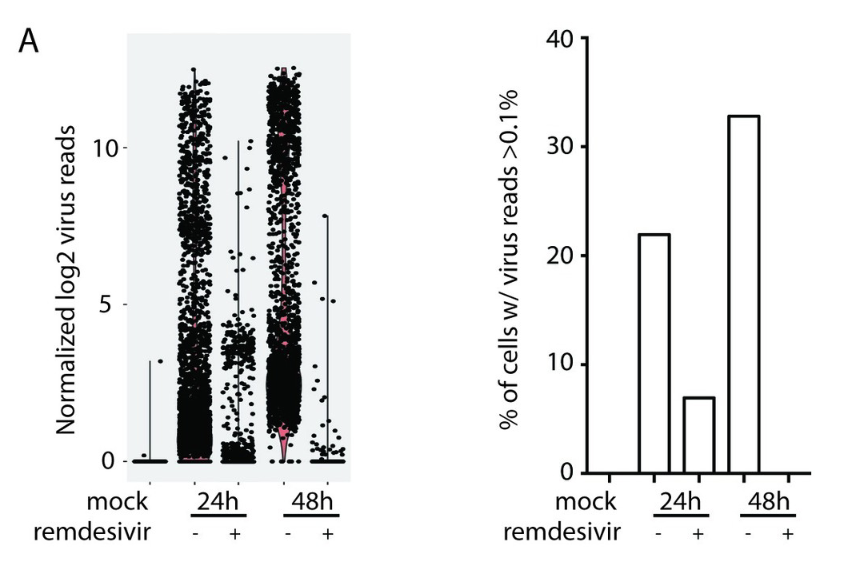

In [50]:
def f(p, adata):
    d = {}
    for trt in adata.obs.treatment.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.treatment == trt)]
        d[trt] = sum(subset.obs.percent_viral.values > .001)/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
# put mock at top
i = df.index.get_loc('mock')
df = df.iloc[[i] + list(range(i)) + list(range(i+1, len(df)))] 

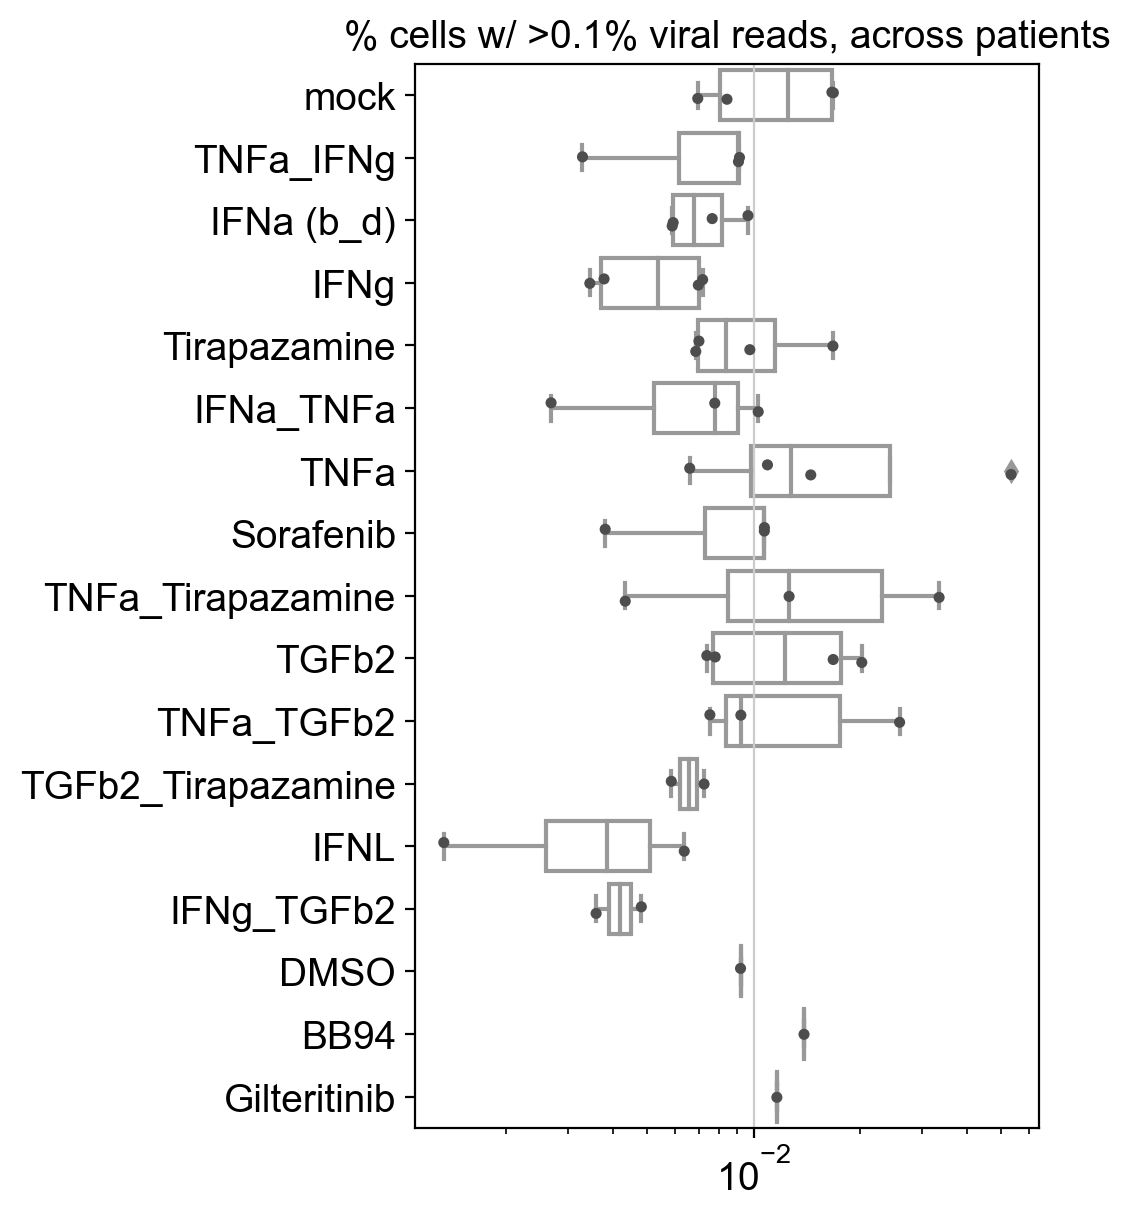

In [53]:
plt.figure(figsize=(4, 7))
plot(df)
plt.xscale('log')
plt.title('% cells w/ >0.1% viral reads, across patients');

#### Based on absolute threshold

In [58]:
def f(p, adata):
    d = {}
    for trt in adata.obs.treatment.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.treatment == trt)]
        d[trt] = sum(subset.obs.viral_counts.values > 10)/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
# put mock at top
i = df.index.get_loc('mock')
df = df.iloc[[i] + list(range(i)) + list(range(i+1, len(df)))] 
# # add column for p-vals
# pvals = [1]
# for p in df.index.values[1:]:
#     pvals.append(-np.log10(ttest_ind(df.T[p][~np.isnan(df.T[p])].values, df.T['mock'].values)[1]))
# df['-log10(pval)'] = pvals
# df

TODO: add p-values based on single-cell viral count values

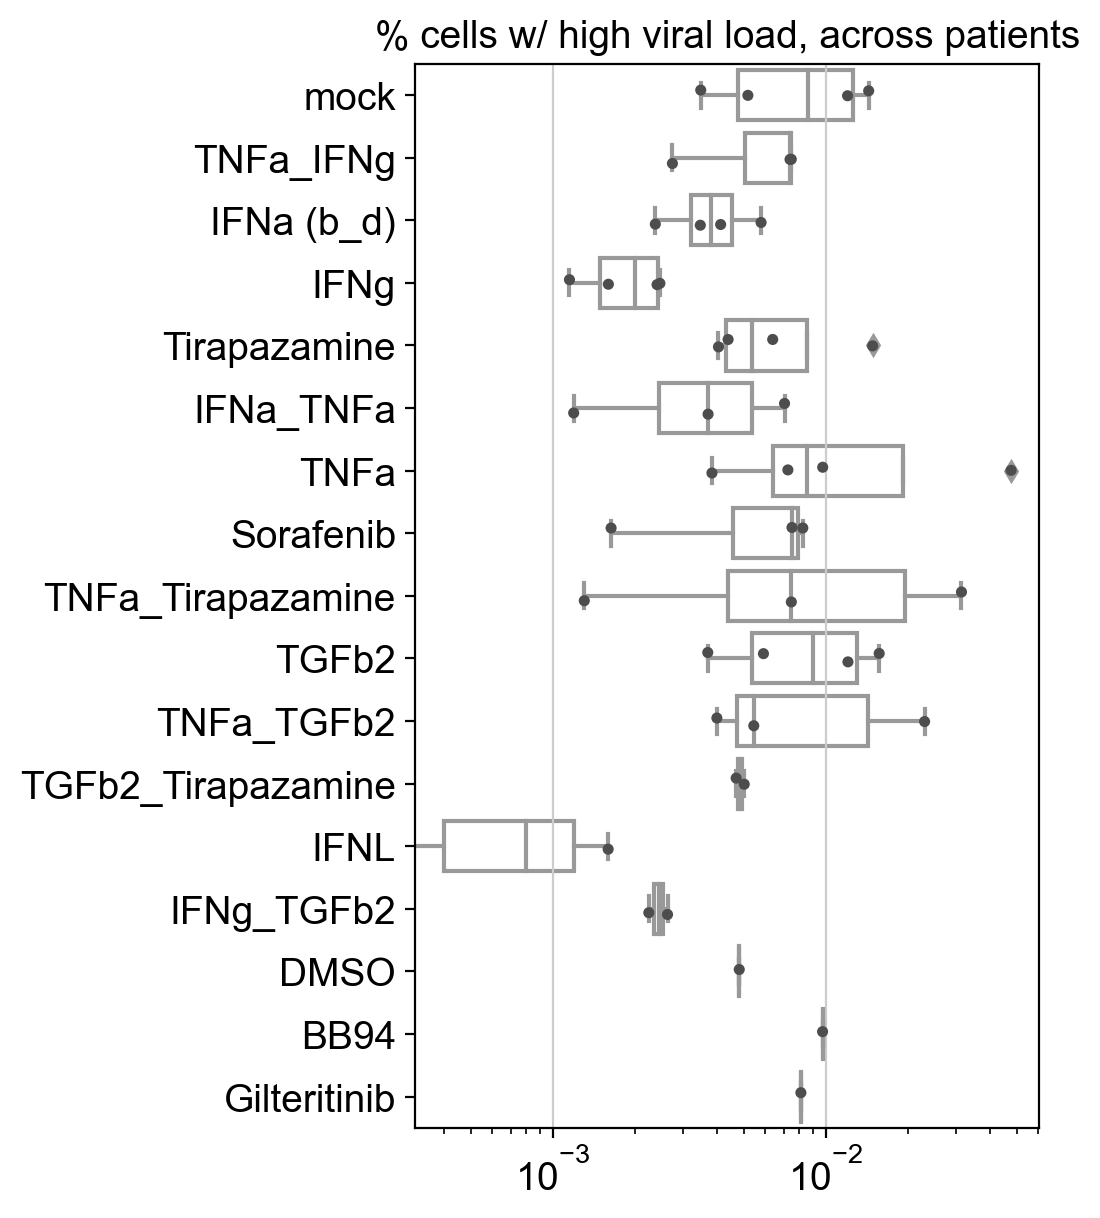

In [59]:
plt.figure(figsize=(4, 7))
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients');
# plt.grid(b=False)

#### check for differences between viral transcript types


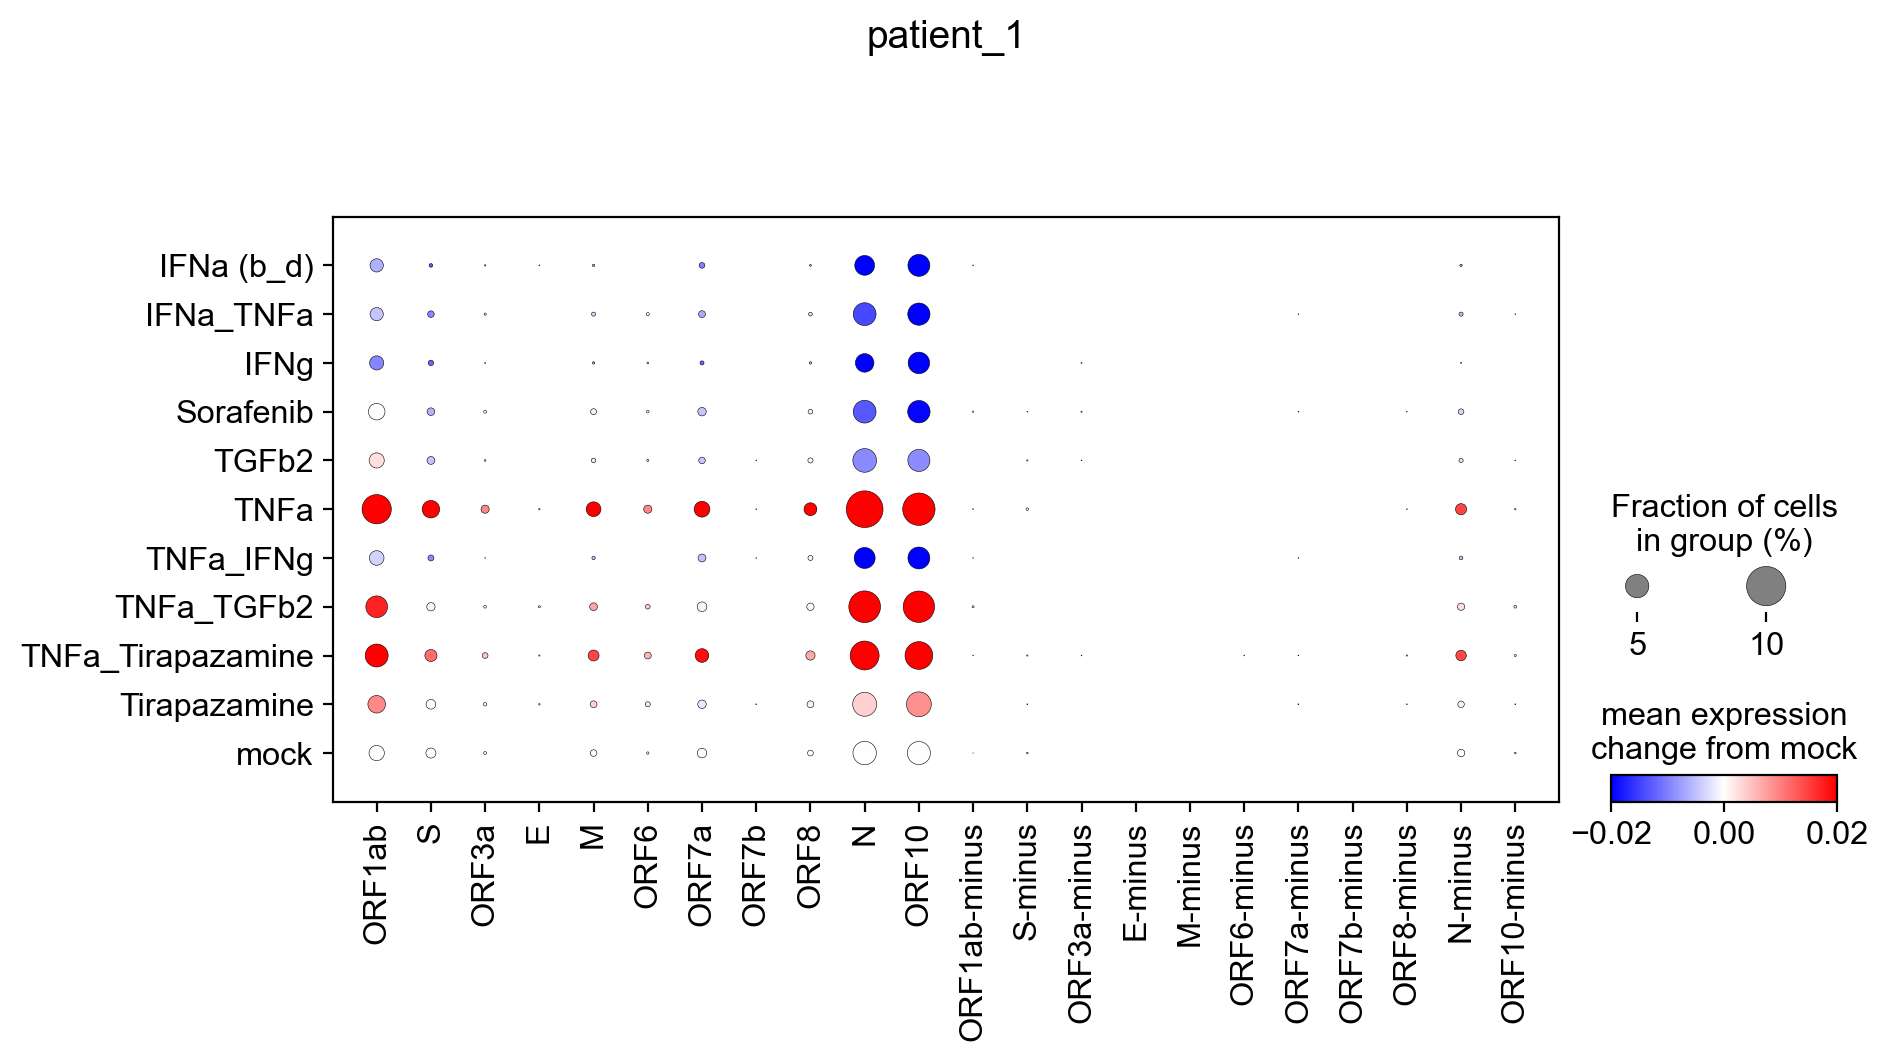

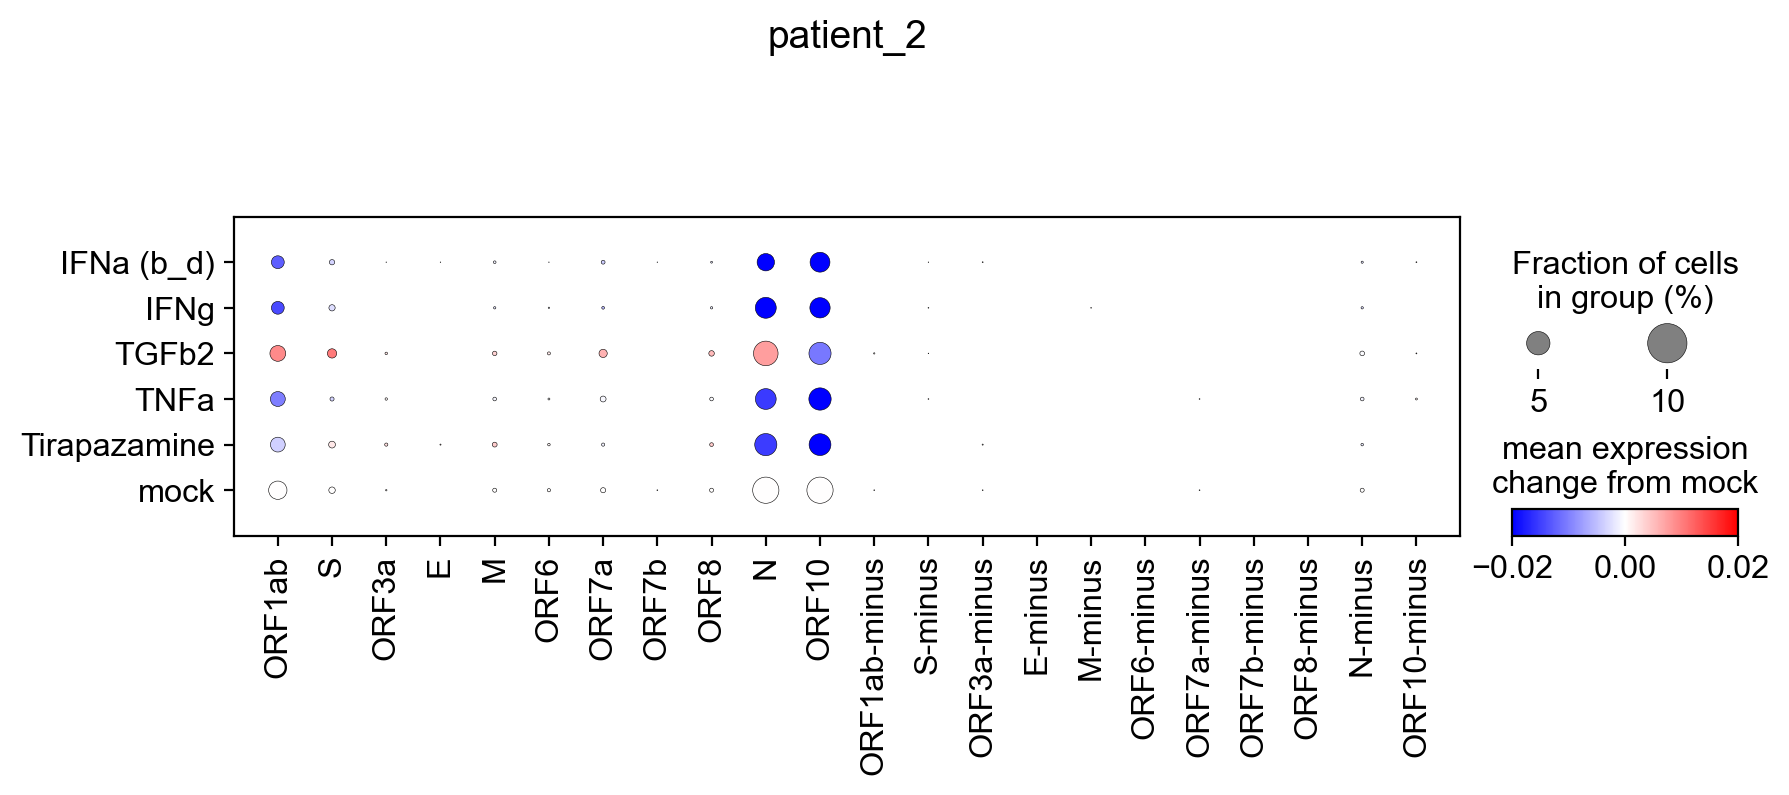

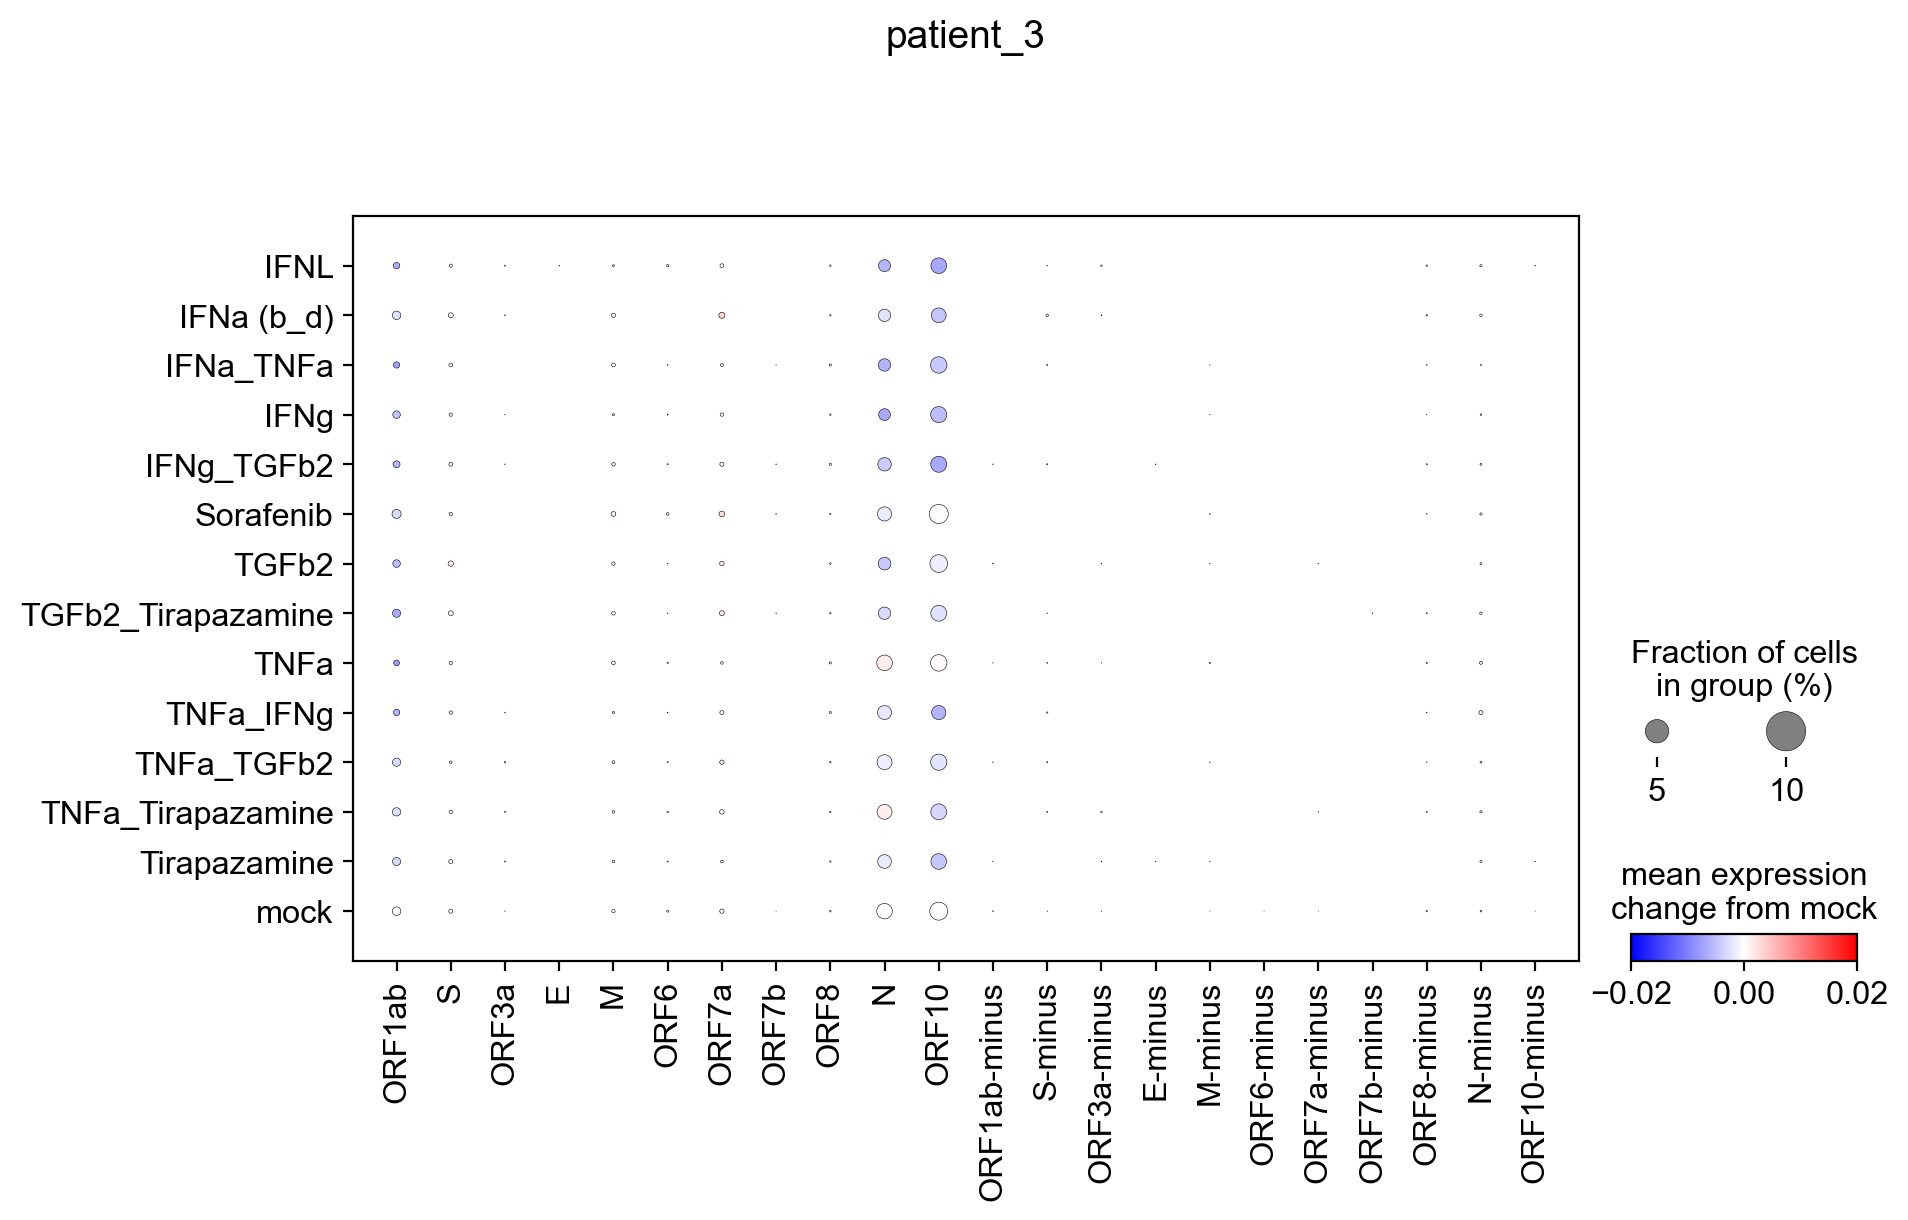

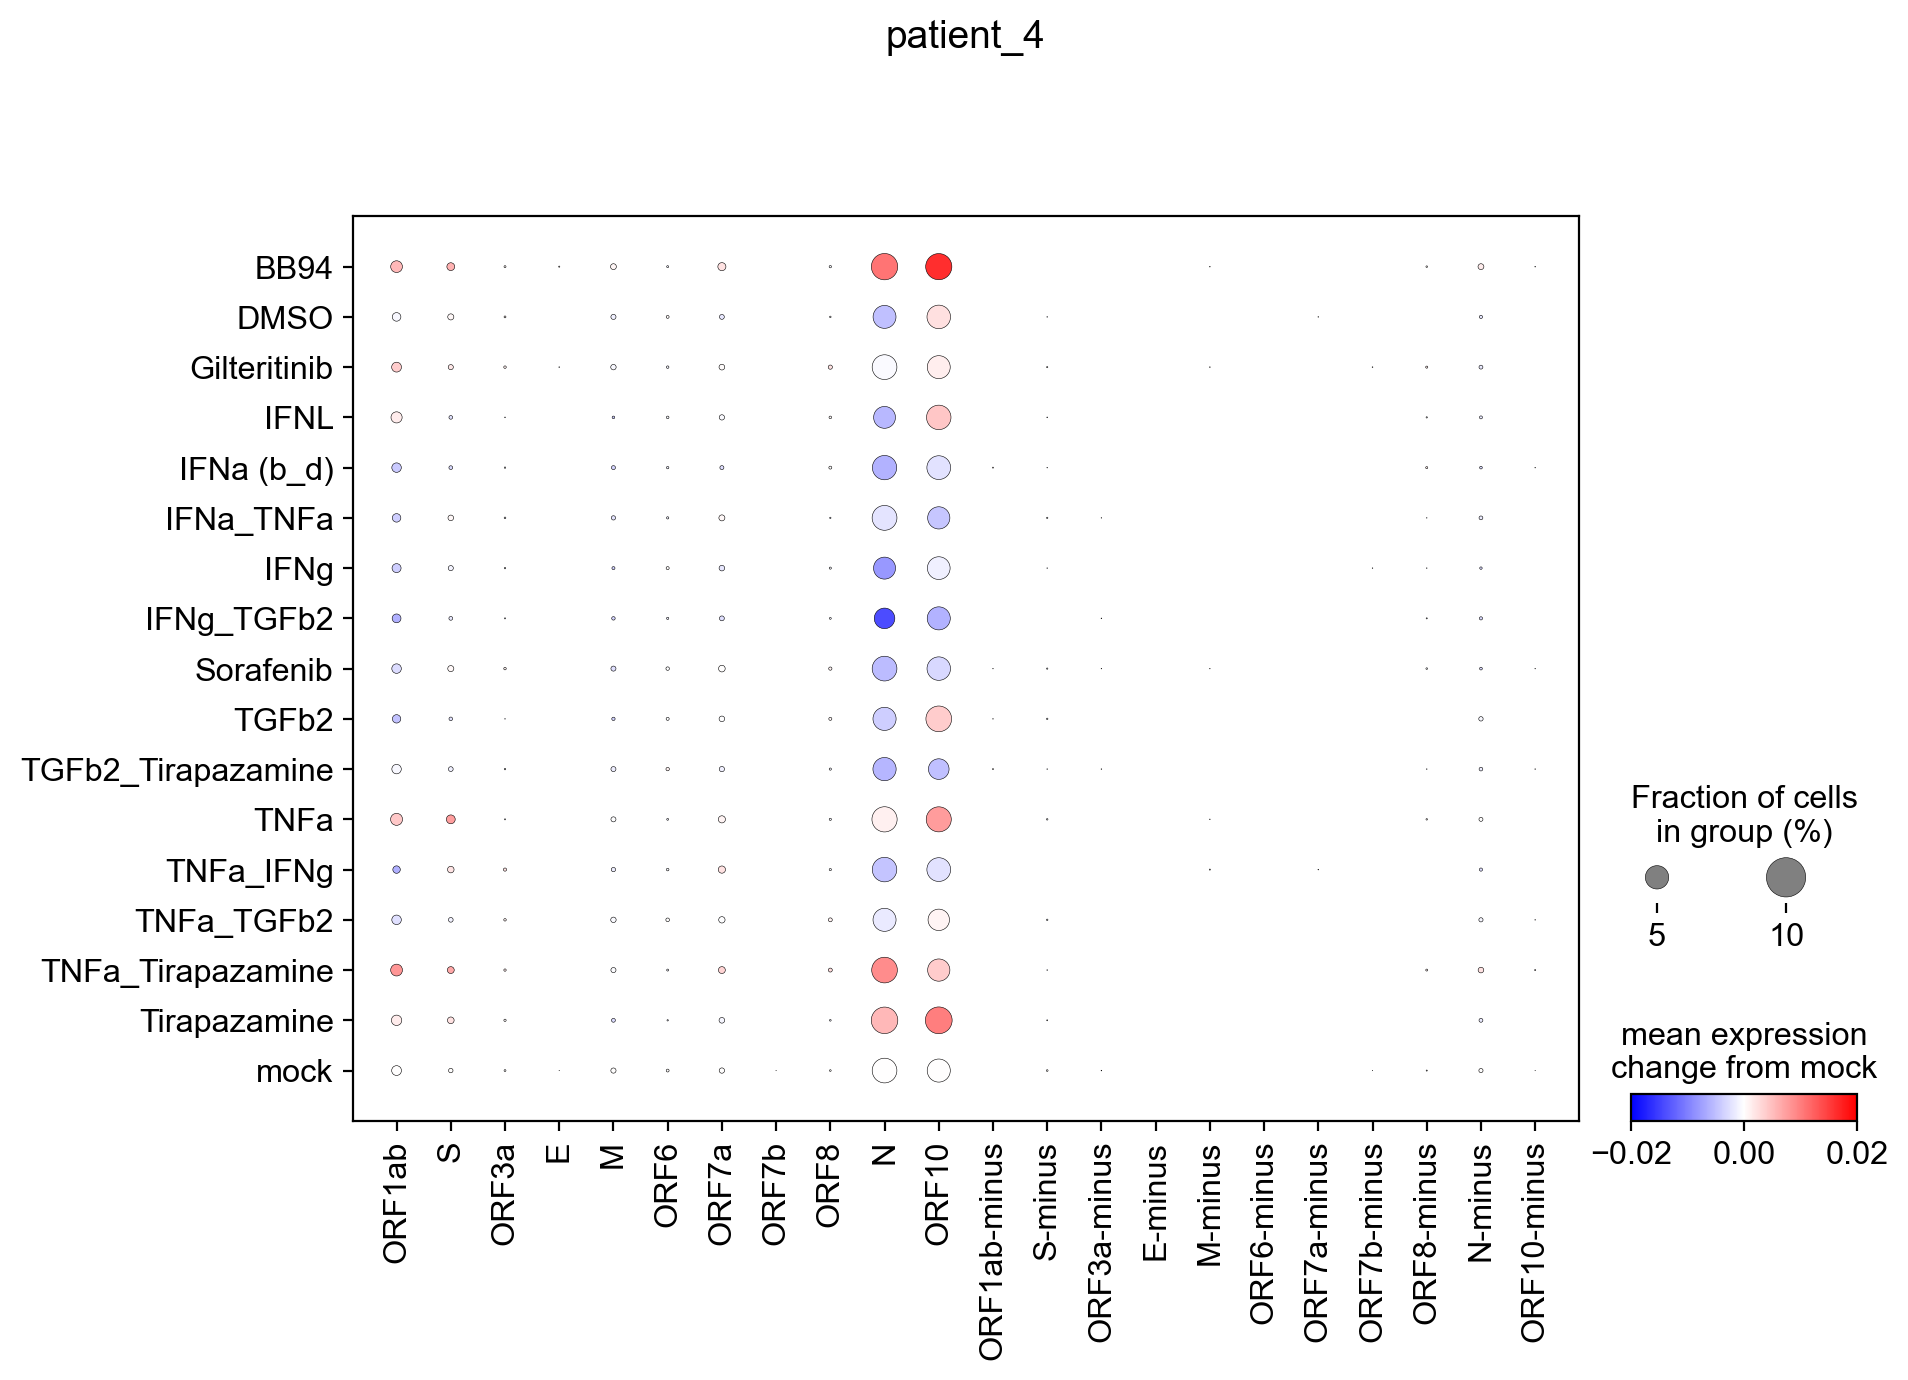

{'patient_1': None, 'patient_2': None, 'patient_3': None, 'patient_4': None}

In [69]:
def f(p, adata):
    subset = adata[adata.obs.infected == True]
    viral_genes = adata.var.index[adatas['patient_3'].var.viral.values]
    fig = sc.pl.dotplot(
        subset, var_names=viral_genes, groupby='treatment',
        return_fig=True)
    sc.pl.dotplot(
        subset, var_names=viral_genes, groupby='treatment',
        dot_color_df = fig.dot_color_df - fig.dot_color_df.loc['mock'],
        cmap='bwr', colorbar_title='mean expression\nchange from mock', vmax=.02, vmin=-.02, title=p)
repeat(f)

Summarized:

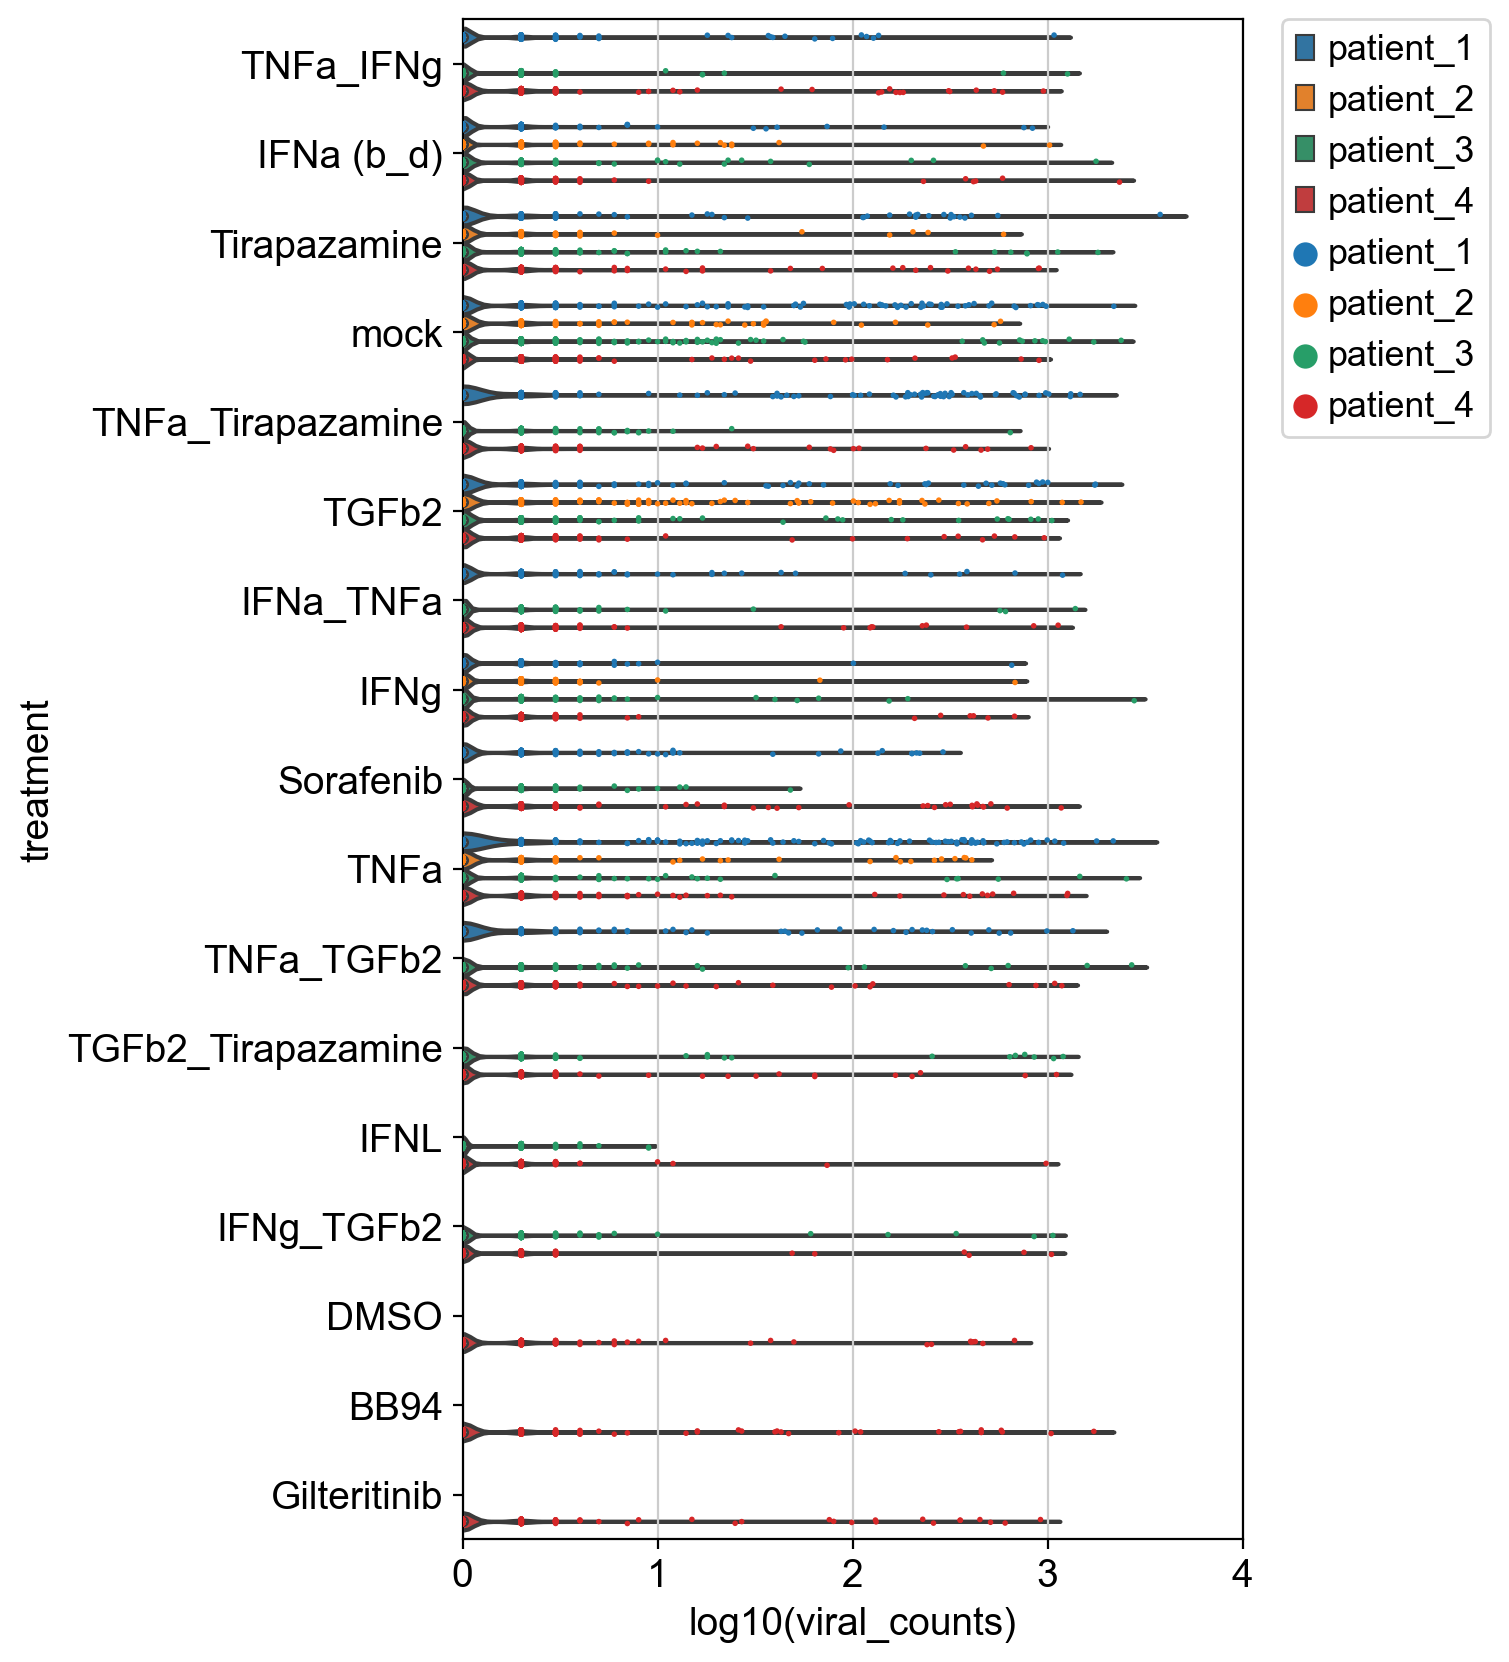

In [57]:
plt.figure(figsize=(5, 10))  # should replace with sc.pl.violin :/
sns.violinplot(
    data=adata[adata.obs.infected == True].obs, x='log10(viral_counts)', y='treatment', hue='patient', scale='width')
sns.stripplot(
    data=adata[adata.obs.infected == True].obs, x='log10(viral_counts)', y='treatment', hue='patient', jitter=1, size=2, dodge=True)
plt.legend(bbox_to_anchor=(1.05, 1),loc=2, borderaxespad=0.)
plt.xlim(0, 4);

### % infected per cell type

First, remove cells that are extremely infected and therefore don't exhibit any specific cell type:

In [21]:
adatas = repeat(lambda p, adata: adata[adata.obs.viral_counts < bg_lvl_high[p]])

In [22]:
# count per cell type
repeat(lambda p, adata: display(
    pd.crosstab(adata[adata.obs.treatment == 'mock'].obs.infected,
                adata[adata.obs.treatment == 'mock'].obs.cell_type)
))

cell_type  basal  ciliated  club  goblet  ionocytes
infected                                           
False       1003         8  2357       4         16
True        1431        19  2389      21         34

cell_type  basal  ciliated  club  goblet  ionocytes
infected                                           
False       1273         2  2080      30          7
True         718        13   886      37         10

cell_type  basal  ciliated  club  ionocytes
infected                                   
False       3332        36  1109          8
True        4595        61  1477         28

cell_type  basal  ciliated  club  goblet  ionocytes
infected                                           
False       1635       140  1833       0         16
True        2147       194  2237       5         10

{'patient_1': None, 'patient_2': None, 'patient_3': None, 'patient_4': None}

Percent of cells per cell type in the virus treated sample (mock only) containing above-background levels of viral transcript, per replicate (patient).

In [23]:
def f(p, adata):
    d = {}
    for ct in adata.obs.cell_type.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.cell_type == ct) & (adata.obs.treatment == 'mock')]
        d[ct] = sum(subset.obs.viral_counts.values > bg_lvl[p])/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
df

patient_1  patient_2  patient_3  patient_4
club        0.010465   0.022573   0.022343   0.003129
basal       0.008386   0.009749   0.001088   0.002329
ionocytes   0.029412   0.000000   0.000000   0.000000
ciliated    0.000000   0.000000   0.000000   0.010309
goblet      1.000000   0.000000        NaN   1.000000

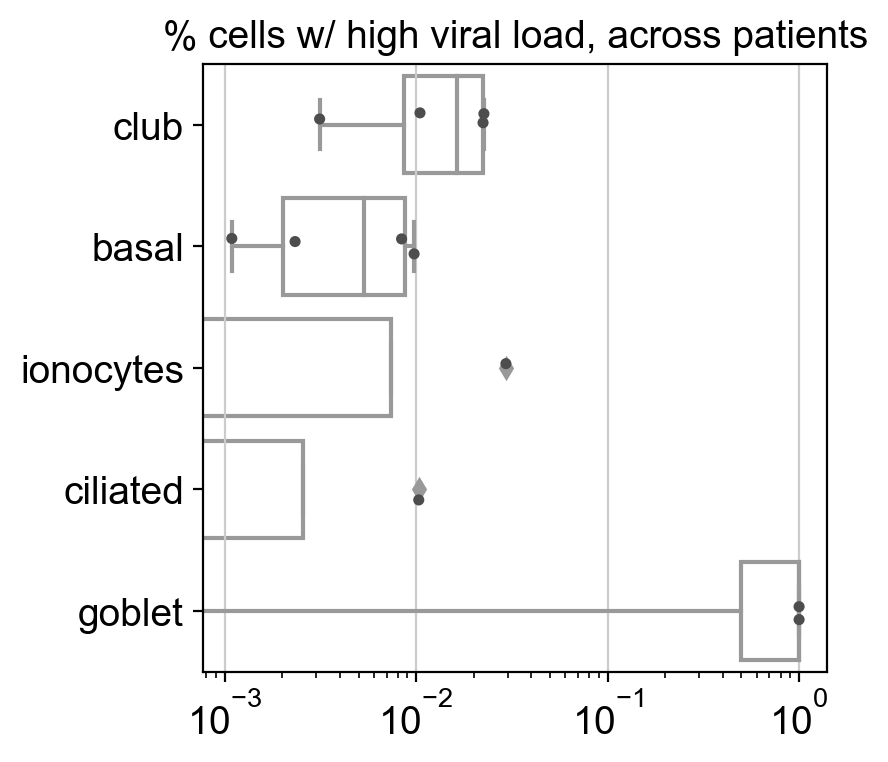

In [24]:
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients');
# plt.grid(b=False)

And as control:

In [25]:
def f(p, adata):
    d = {}
    for ct in adata.obs.cell_type.unique():
        subset = adata[(adata.obs.infected == False) & (adata.obs.cell_type == ct) & (adata.obs.treatment == 'mock')]
        d[ct] = sum(subset.obs.viral_counts.values > bg_lvl[p])/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
df

patient_1  patient_2  patient_3  patient_4
club        0.006364   0.007692   0.018034   0.001637
basal       0.004985   0.007855   0.001200   0.001223
ionocytes   0.000000   0.000000   0.000000   0.000000
ciliated    0.000000   0.000000   0.000000   0.007143
goblet      1.000000   0.000000        NaN   0.000000

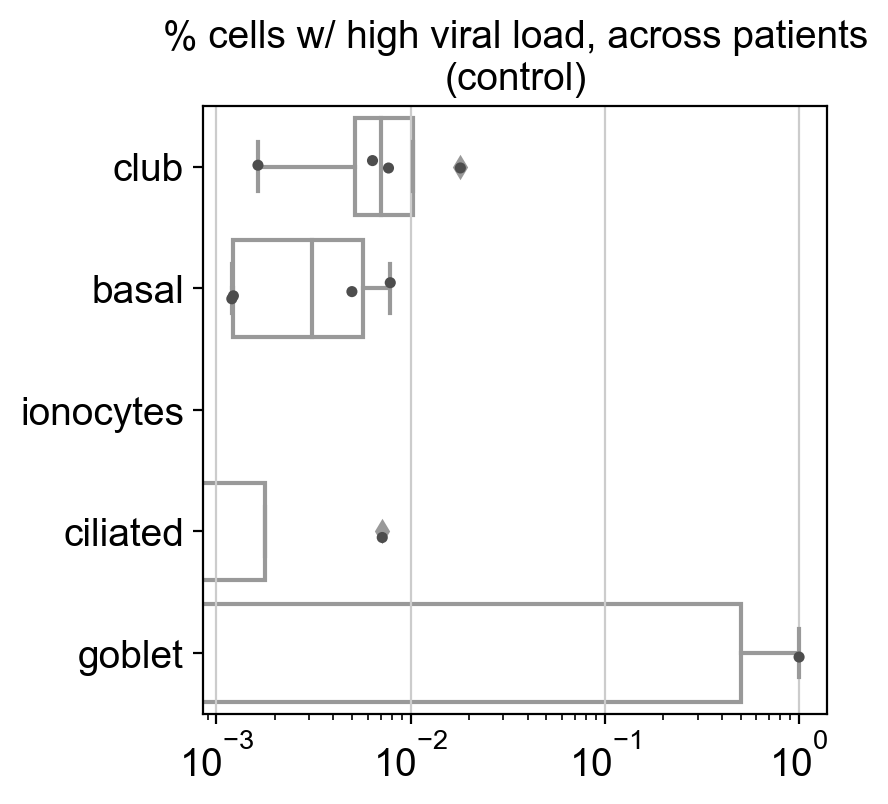

In [26]:
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients\n(control)');

With more samples (including all shared compounds so it's still comparable) - mostly as a sanity check since the counts for some cell types were extremely low. We can't make statements from this plot.

In [27]:
df = pd.crosstab(adata.obs.patient, adata.obs.treatment)
shared_cmpds = df.columns[df.all().values]

In [28]:
def f(p, adata):
    d = {}
    for ct in adata.obs.cell_type.unique():
        subset = adata[(adata.obs.infected == True) & (adata.obs.cell_type == ct) & (adata.obs.treatment.isin(shared_cmpds))]
        d[ct] = sum(subset.obs.viral_counts.values > bg_lvl[p])/subset.shape[0] if subset.shape[0] else 0 
    return d
perc_infected = repeat(f)

df = pd.DataFrame.from_dict(perc_infected)
df

patient_1  patient_2  patient_3  patient_4
club        0.013141   0.014043   0.017771   0.003971
basal       0.014016   0.008220   0.001304   0.001858
ionocytes   0.012500   0.000000   0.000000   0.000000
ciliated    0.000000   0.013699   0.000000   0.011111
goblet      1.000000   0.000000        NaN   1.000000

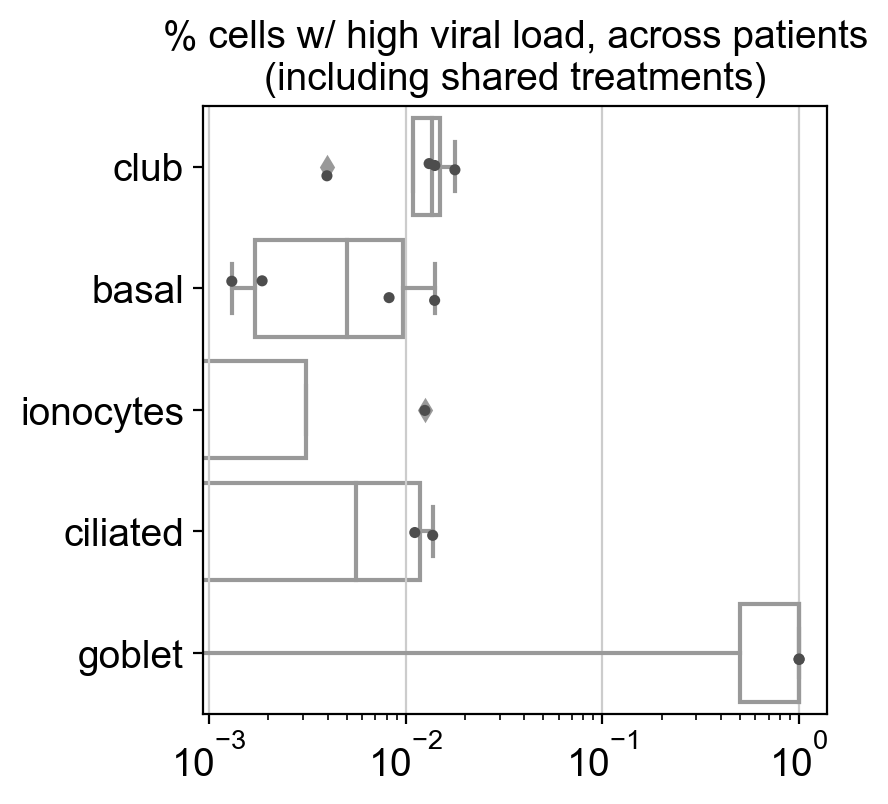

In [29]:
plot(df)
plt.xscale('log')
plt.title('% cells w/ high viral load, across patients\n(including shared treatments)');